# SOURCE CODE FOR TASK C

#### Import Libraries

In [34]:
# Libraries for Network Analysis
import random
import osmnx as ox
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.cluster import KMeans
import shapely.geometry as geometry
from shapely.geometry import Polygon, Point, LineString
from scipy.spatial import Voronoi, voronoi_plot_2d

#### Create the Voronoi Diagram with 10 seeds (Seeds are the Bus Stops)

In [2]:

# Get the city boundary of Leeds
city = ox.geocode_to_gdf("Leeds, UK")
city_boundary = city.geometry.iloc[0]

# Get public transport stops in Leeds
public_transport_stops = ox.geometries_from_polygon(city_boundary, tags={"highway": "bus_stop"})

# Create a GeoDataFrame with the stops as points
stops_gdf = gpd.GeoDataFrame(geometry=[Point(pt.x, pt.y) \
                                       for pt in public_transport_stops.geometry.centroid])

# Create a DataFrame with coordinates of the public transport stops
coordinates = [(pt.x, pt.y) for pt in stops_gdf.geometry]
coord_df = pd.DataFrame(coordinates, columns=['x', 'y'])

# Perform KMeans clustering to find 10 clusters
kmeans = KMeans(n_clusters=10, random_state=0).fit(coord_df)

# Get the cluster centroids (seed points)
centroids = kmeans.cluster_centers_

# Create a GeoDataFrame with seed points
seed_points_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in centroids])


# Get Voronoi diagram
vor = Voronoi([pt.coords[0] for pt in seed_points_gdf.geometry])

/var/folders/vt/2mzv1ntx6_z_m5dz683z2d5h0000gn/T/ipykernel_39521/2651123155.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for pt in public_transport_stops.geometry.centroid])
/Users/mahsumkocabey/Desktop/MSc Data Science/Sem 2/Network Analysis/CW2/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [3]:
centroids

array([[-1.60908078, 53.82407791],
       [-1.49859374, 53.7495624 ],
       [-1.46195962, 53.81734555],
       [-1.53852551, 53.79706743],
       [-1.5842425 , 53.75054322],
       [-1.687003  , 53.8799253 ],
       [-1.38283866, 53.9088881 ],
       [-1.66011614, 53.79445393],
       [-1.38506673, 53.77409252],
       [-1.5369924 , 53.84172329]])

#### Visualize Voronoi diagram

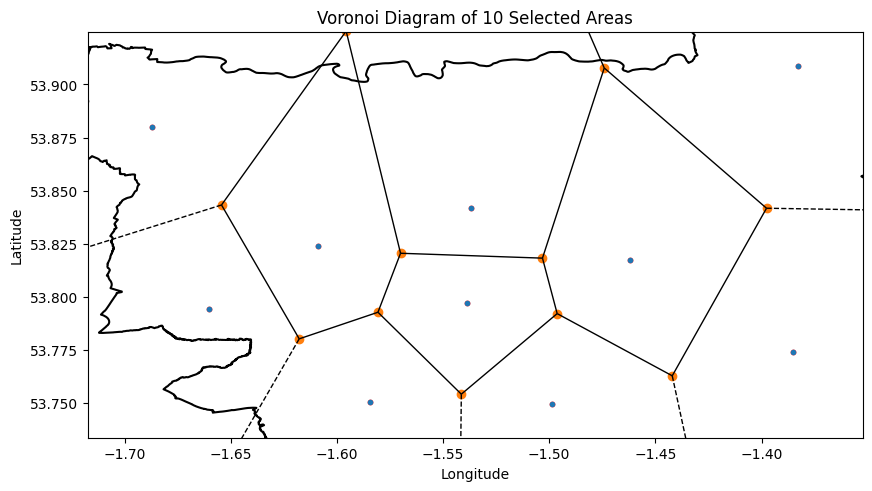

In [4]:
# Visualize Voronoi diagram
fig, ax = plt.subplots(figsize=(10,10))
voronoi_plot_2d(vor, ax=ax)
city.boundary.plot(ax=ax, color='k')
seed_points_gdf.plot(ax=ax, markersize=10, color='red')
plt.title("Voronoi Diagram of 10 Selected Areas")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.savefig("voronoi_diagram", dpi=200)
plt.show()

----------------

#### Find paths for marathons

In [5]:

def dfs(G, node, visited, path, path_length, target_length, tolerance=100):
    # If the current node has been visited, return None
    if node in visited:
        return None

    # If the current path length is within the tolerance of the target length, return the path
    if abs(path_length - target_length) <= tolerance:
        return path

    # Mark the current node as visited
    visited.add(node)

    # Iterate through the neighbors of the current node
    for neighbor, edge_data in G[node].items():
        # Iterate through the edge attributes
        for key, edge_attrs in edge_data.items():
            # Get the length of the current edge
            edge_length = edge_attrs["length"]
            # Create a new path by appending the neighbor to the current path
            new_path = path + [neighbor]
            # Calculate the new path length by adding the edge length to the current path length
            new_length = path_length + edge_length
            # Recursively call the dfs function with the new path and new path length
            result = dfs(G, neighbor, visited, new_path, new_length, target_length, tolerance)

            # If a valid path is found, return it
            if result is not None:
                return result

    # If no valid path is found, remove the current node from the visited set and return None
    visited.remove(node)
    return None

def find_circuit(G, start_point, target_length, tolerance=100):
    # Convert the start_point to a Point object if it isn't one already
    if not isinstance(start_point, Point):
        start_point = Point(start_point)

    # Find the nearest node in the graph to the start_point
    start_node = ox.distance.nearest_nodes(G, [start_point.x], [start_point.y])[0]
    # Initialize an empty set of visited nodes
    visited = set()
    # Call the dfs function to find a path with the desired length
    path = dfs(G, start_node, visited, [start_node], 0, target_length, tolerance)

    # If a path is found, calculate its total length
    if path is not None:
        path_length = sum(ox.utils_graph.get_route_edge_attributes(G, path, "length"))
    else:
        path_length = None

    # Return the path and its length
    return path, path_length

In [6]:

# Get Leeds road network
G = ox.graph_from_polygon(city_boundary, network_type='all')

In [21]:
selected_cells = [7,1,2]  # Select first 3 cells as an example
selected_paths = []

for cell_idx, v in enumerate(selected_cells):
    start_point = centroids[v]
    path, path_length = find_circuit(G, start_point, 42_000)
    
    if path is not None:
        print(f"Found a path for cell {cell_idx+1} with length {path_length} meters")
        # Get the coordinates of the starting and ending nodes in the path
        start_coordinate = (G.nodes[path[0]]['y'], G.nodes[path[0]]['x'])
        end_coordinate = (G.nodes[path[-1]]['y'], G.nodes[path[-1]]['x'])
        print(f"Starting coordinate for cell {cell_idx+1}: {start_coordinate}")
        print(f"Ending coordinate for cell {cell_idx+1}: {end_coordinate}")
        selected_paths.append(path)
        print("")
    else:
        print(f"Couldn't find a suitable path for cell {cell_idx+1}")

Found a path for cell 1 with length 41893.23799999998 meters
Starting coordinate for cell 1: (53.7946335, -1.6602951)
Ending coordinate for cell 1: (53.7504318, -1.6340209)

Found a path for cell 2 with length 41894.29400000003 meters
Starting coordinate for cell 2: (53.7478232, -1.4983541)
Ending coordinate for cell 2: (53.7812057, -1.4328268)

Found a path for cell 3 with length 41888.49800000003 meters
Starting coordinate for cell 3: (53.8173731, -1.4621972)
Ending coordinate for cell 3: (53.8087262, -1.4905369)



#### Visualise the paths along with seeds

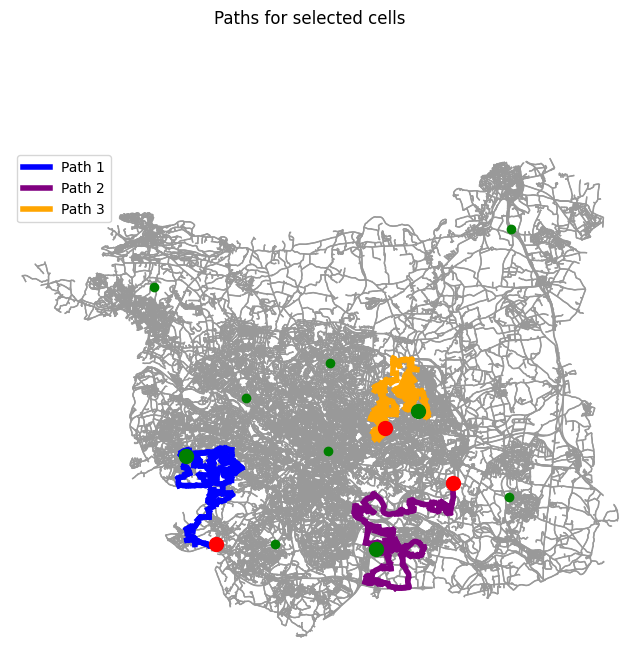

In [33]:
def plot_route_with_colors(G, path, ax, path_number, route_color='blue', orig_dest_color='green', orig_end_color='red'):
    for index in range(len(path) - 1):
        u, v = path[index], path[index + 1]
        edge = G.get_edge_data(u, v, key=0)
        if edge is not None and 'geometry' in edge:
            linestring = edge['geometry']
            if isinstance(linestring, LineString):
                xs, ys = linestring.xy
                ax.plot(xs, ys, c=route_color, linewidth=4, label=f'Path {path_number}' if index == 0 else '')

    orig = G.nodes[path[0]]
    dest = G.nodes[path[-1]]

    ax.scatter(orig['x'], orig['y'], c=orig_dest_color, s=100, zorder=3)
    ax.scatter(dest['x'], dest['y'], c=orig_end_color, s=100, zorder=3)

def plot_centroids(centroids, ax):
    for x, y in centroids:
        ax.scatter(x, y, c='green', marker='o')


# Define a list of colors
colors = ['blue', 'purple', 'orange']

# Plot the graph
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False, bgcolor='white')

# Plot the centroids
plot_centroids(centroids, ax)

# Plot the paths on the same graph
for i, path in enumerate(selected_paths):
    plot_route_with_colors(G, path, ax, i + 1, route_color=colors[i % len(colors)])

# Add the title and display the graph
fig.suptitle("Paths for selected cells")

# Create a custom legend
legend_handles = [mlines.Line2D([], [], color=colors[i % len(colors)], linewidth=4, label=f'Path {i + 1}') for i in range(len(selected_paths))]
ax.legend(handles=legend_handles, loc='upper left')
plt.savefig("Paths for selected cells", dpi=200)
plt.show()